# Recurrent Neural Network (Времянные ряды)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

In [2]:
DATA_PATH = './data/airline-passengers.csv'
TEST_SIZE = 0.33

LOOK_BACK = 3
BATCH_SIZE = 2

## Загрузка и подготовка данных

In [3]:
scaler = MinMaxScaler()

data = pd.read_csv(DATA_PATH,  usecols=[1])
data = scaler.fit_transform(data)

In [4]:
def create_dataset(data, look_back=1):
    X, y = [], []

    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i+look_back, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

In [5]:
train_size = int(len(data) * (1 - TEST_SIZE))

X_train, y_train = create_dataset(data[0:train_size, :], LOOK_BACK)
X_test, y_test = create_dataset(data[train_size:, :], LOOK_BACK)

## Модель

In [6]:
model = Sequential()
model.add(LSTM(16, batch_input_shape=(BATCH_SIZE, LOOK_BACK, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(8))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

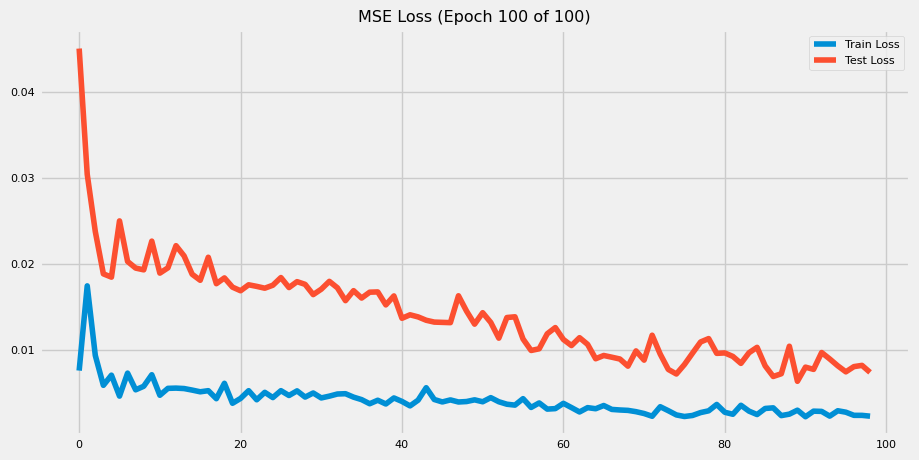

46/46 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0074


In [7]:
losses = [[], []]

epochs = 100
for i in range(epochs):
    clear_output(wait=True)
    print()
    
    plt.figure(figsize=(10, 5))
    plt.plot(losses[0], label='Train Loss')
    plt.plot(losses[1], label='Test Loss')
    plt.title(f'MSE Loss (Epoch {i+1} of {epochs})')
    plt.grid(True)
    plt.legend()
    plt.show()

    history = model.fit(X_train, y_train,
                        epochs=1,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test),
                        shuffle=False)
    model.reset_states()

    losses[0].append(history.history['loss'])
    losses[1].append(history.history['val_loss'])

In [8]:
train_pred = model.predict(X_train, batch_size=BATCH_SIZE, verbose=0)
test_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

In [9]:
train_pred = scaler.inverse_transform(train_pred)[:, 0]
test_pred = scaler.inverse_transform(test_pred)[:, 0]

y_train = scaler.inverse_transform([y_train])[0]
y_test = scaler.inverse_transform([y_test])[0]

In [10]:
train_score = mse(y_train, train_pred, squared=False)
test_score = mse(y_test, test_pred, squared=False)

print(f'Train Score {train_score:0.4f} RMSE')
print(f'Test Score {test_score:0.4f} RMSE')

Train Score 23.0907 RMSE
Test Score 44.4844 RMSE


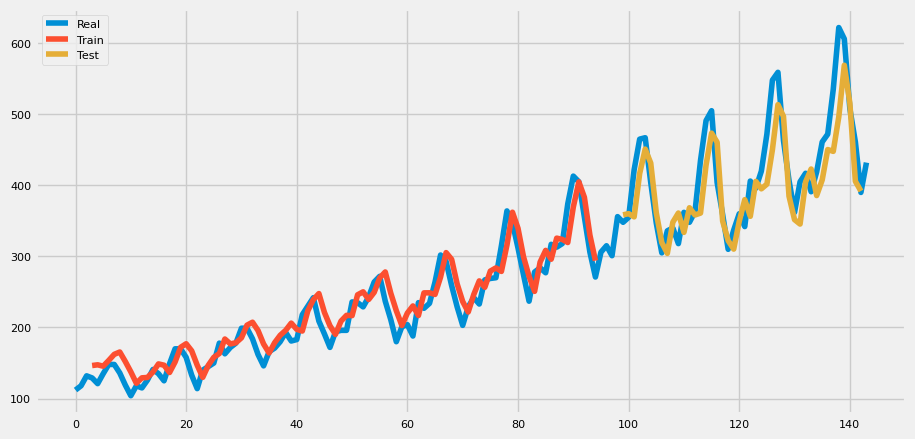

In [11]:
train_pred_plot = np.empty_like(data[:, 0])
test_pred_plot = np.empty_like(data[:, 0])

train_pred_plot[:] = np.nan
test_pred_plot[:] = np.nan

train_pred_plot[LOOK_BACK:len(train_pred)+LOOK_BACK] = train_pred
test_pred_plot[len(train_pred)+(LOOK_BACK*2)+1:len(data)-1] = test_pred

plt.figure(figsize=(10, 5))
plt.plot(scaler.inverse_transform(data), label='Real')
plt.plot(train_pred_plot, label='Train')
plt.plot(test_pred_plot, label='Test')
plt.legend()
plt.show()